# Example 4: 2nd-level Analysis

Last but not least, the 2nd-level analysis. After we normalized all subject data into template space, we can now do the group analysis. To show the flexibility of Nipype, we will run the group analysis on data with two different smoothing kernel (fwhm= [4, 8]) and two different normalization (ANTs and SPM).

This example will also directly include thresholding of the output, as well as some visualization.

**Let's start!**

# Group Analysis with SPM

let's first run the group analysis with the SPM normalized data.

## Imports

First, we need to import all modules we later want to use.

In [1]:
%pylab inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype.pipeline.engine import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

Populating the interactive namespace from numpy and matplotlib


## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [2]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 'con_0006', 'con_0007']

mask = "/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/2mm_brainmask.nii.gz"

## Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [3]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [4]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'norm_spm', 'sub-*_fwhm{fwhm_id}',
                         'w{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [5]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

## Visualize the workflow

It always helps to visualize your workflow.

170731-11:30:19,752 workflow INFO:
	 Generated workflow graph: /output/workingdir/l2analysis/graph.dot.png (graph2use=colored, simple_form=True).


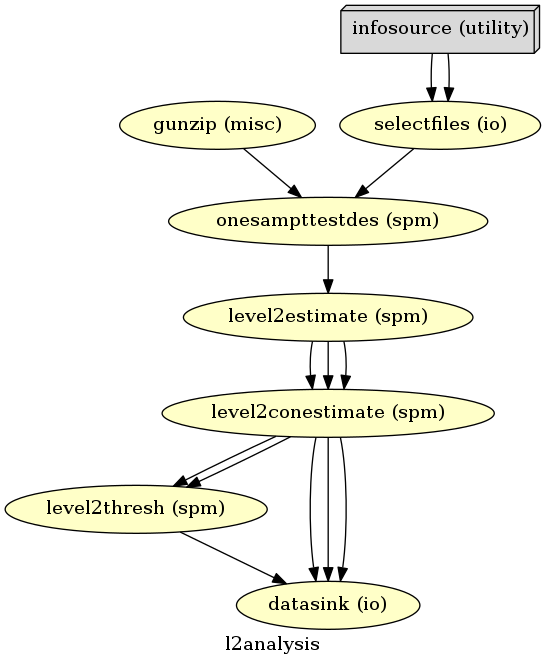

In [6]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'l2analysis', 'graph.dot.png'))

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [7]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

170731-11:33:18,797 workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging']
170731-11:33:18,922 workflow INFO:
	 Running in parallel.
170731-11:33:18,934 workflow INFO:
	 Executing: selectfiles.a13 ID: 0
170731-11:33:18,943 workflow INFO:
	 Executing: selectfiles.a12 ID: 1
170731-11:33:18,949 workflow INFO:
	 Executing: selectfiles.a11 ID: 2
170731-11:33:18,959 workflow INFO:
	 Executing: selectfiles.a10 ID: 3
170731-11:33:18,953 workflow INFO:
	 Executing node selectfiles.a12 in dir: /output/workingdir/l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles170731-11:33:18,946 workflow INFO:
	 Executing node selectfiles.a13 in dir: /output/workingdir/l2analysis/_contrast_id_con_0007_fwhm_id_8/selectfiles
170731-11:33:18,966 workflow INFO:
	 Executing node selectfiles.a11 in dir: /output/workingdir/l2analysis/_contrast_id_con_0006_fwhm_id_8/selectfiles170731-11:33:18,973 workflow INFO:
	 Executing node selectfiles.a10 in dir: /output/workingdir/l2analysis/_contra

# Group Analysis with ANTs

Now to run the same group analysis, but on the ANTs normalized images, we just need to change a few parameters:

In [8]:
# Change the SelectFiles template and recreate the node
templates = {'cons': opj(output_dir, 'norm_ants', 'sub-*_fwhm{fwhm_id}',
                         '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'ants_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

Now, we just have to recreate the workflow.

In [9]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

And we can run it!

In [10]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

170731-11:44:39,499 workflow INFO:
	 Workflow l2analysis settings: ['check', 'execution', 'logging']
170731-11:44:39,611 workflow INFO:
	 Running in parallel.
170731-11:44:39,617 workflow INFO:
	 Executing: selectfiles.a13 ID: 0
170731-11:44:39,626 workflow INFO:
	 Executing: selectfiles.a12 ID: 1
170731-11:44:39,629 workflow INFO:
	 Executing node selectfiles.a13 in dir: /output/workingdir/l2analysis/_contrast_id_con_0007_fwhm_id_8/selectfiles
170731-11:44:39,637 workflow INFO:
	 Executing: selectfiles.a11 ID: 2
170731-11:44:39,639 workflow INFO:
	 Executing node selectfiles.a12 in dir: /output/workingdir/l2analysis/_contrast_id_con_0007_fwhm_id_4/selectfiles170731-11:44:39,647 workflow INFO:
	 Executing: selectfiles.a10 ID: 3

170731-11:44:39,651 workflow INFO:
	 Executing node selectfiles.a11 in dir: /output/workingdir/l2analysis/_contrast_id_con_0006_fwhm_id_8/selectfiles
170731-11:44:39,660 workflow INFO:
	 Executing node selectfiles.a10 in dir: /output/workingdir/l2analysis/_cont

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**Keep in mind, that the group analysis was only done on *`N=2`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **all actions > mean**:

Populating the interactive namespace from numpy and matplotlib


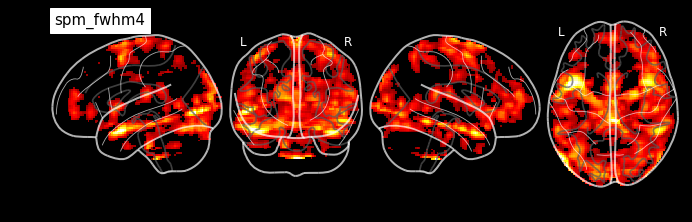

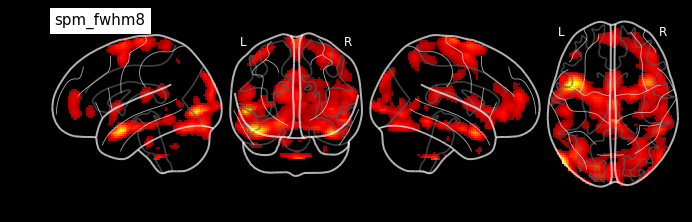

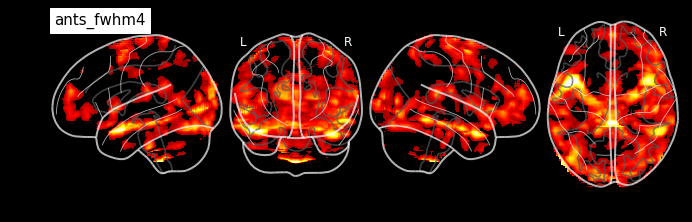

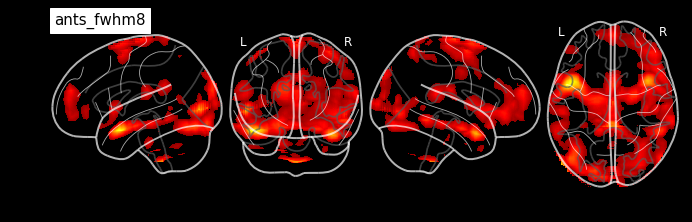

In [16]:
%pylab inline
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm4/con_0001.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=5, title='spm_fwhm4')
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm8/con_0001.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=5, title='spm_fwhm8')
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/con_0001.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=5, title='ants_fwhm4')
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm8/con_0001.nii',
    threshold=1, display_mode='lyrz', black_bg=True, vmax=5, title='ants_fwhm8')

The results are more or less what you would expect: The peaks are more or less at the same places for the two normalization approaches and a wider smoothing has the effect of bigger clusters, while losing the sensitivity for smaller clusters.

But if we look at the first contrast **congruent**, we see a different picture. In this case, the normalization with SPM seems to be more sensitive to the detection of significant voxels. Now the question is open if this is because of increased sensitivity or if this caused by an inherent normalization flaw in SPM or ANTs.

/opt/conda/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


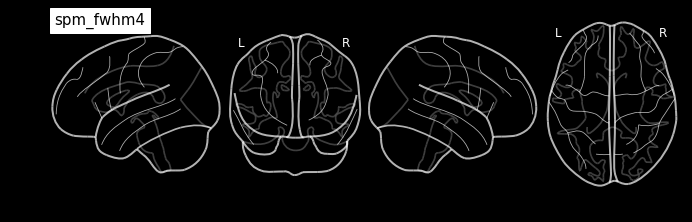

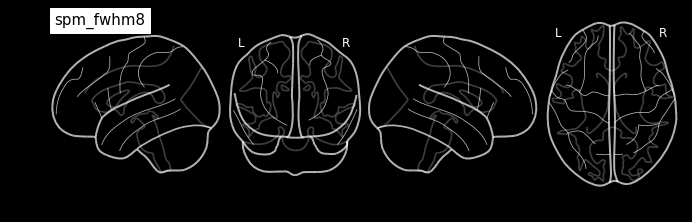

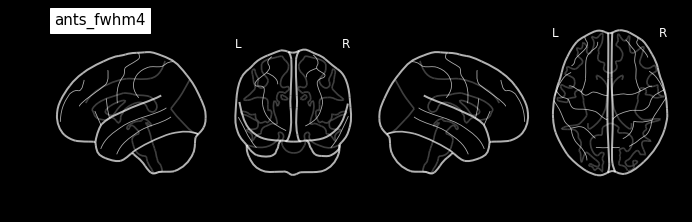

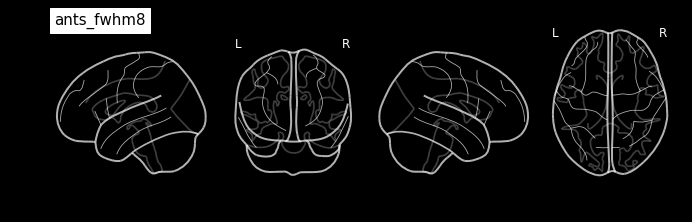

In [9]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm4/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='spm_fwhm4')
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm8/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='spm_fwhm8')
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='ants_fwhm4')
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm8/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='ants_fwhm8')

Last but not least, let's look at the contrast **incongruent**.

/opt/conda/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


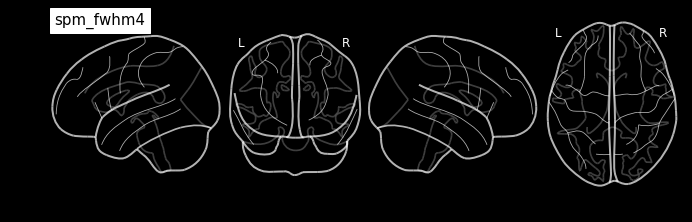

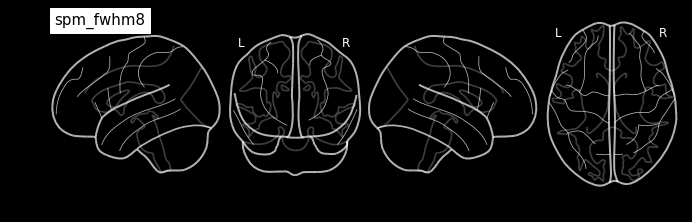

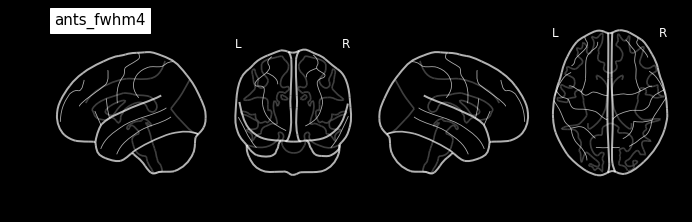

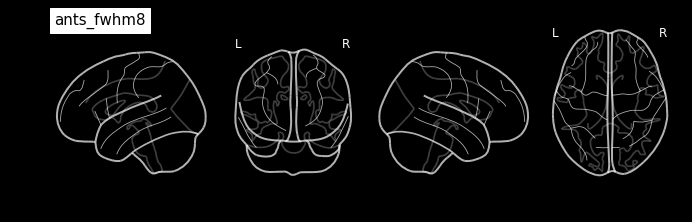

In [10]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0002_fwhm4/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='spm_fwhm4')
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='spm_fwhm8')
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0002_fwhm4/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='ants_fwhm4')
plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0002_fwhm8/spmT_0001_thr.nii',
    threshold=0, display_mode='lyrz', black_bg=True, vmax=20, title='ants_fwhm8')

Where before a smoothing of FWHM=4mm seemed to be more sensitive, here only smoothing of FWHM=8mm seems to pick up some results. Let's get some better understanding about where this significant cluster is located.

/opt/conda/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:674: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


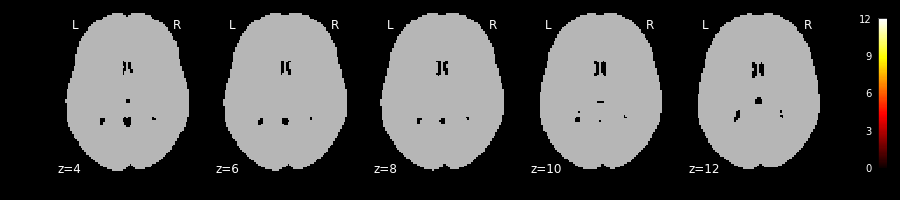

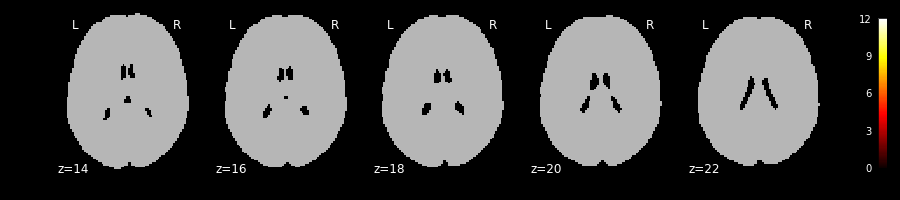

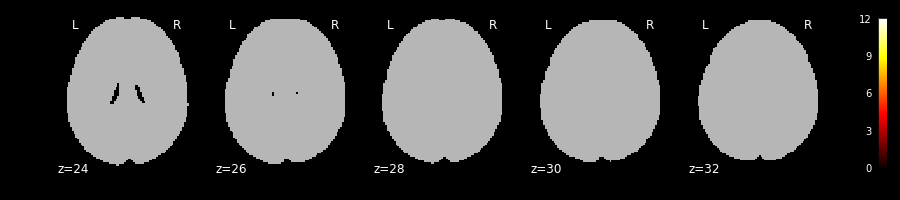

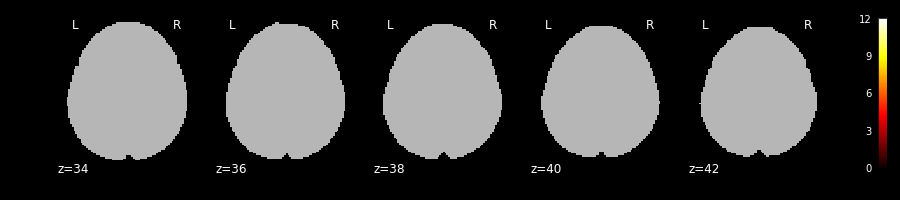

In [14]:
from nilearn.plotting import plot_stat_map
anatimg = "/data/templates/fsl/MNI152_T1_2mm_brain_mask.nii.gz" #DJ: copied
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001_thr.nii',
    cut_coords=(4, 6, 8, 10, 12),
    bg_img=anatimg, threshold=0, display_mode='z', vmax=12)
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001_thr.nii',
    cut_coords=(14, 16, 18, 20, 22),
    bg_img=anatimg, threshold=0, display_mode='z', vmax=12)
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001_thr.nii',
    cut_coords=(24, 26, 28, 30, 32),
    bg_img=anatimg, threshold=0, display_mode='z', vmax=12)
plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0002_fwhm8/spmT_0001_thr.nii',
    cut_coords=(34, 36, 38, 40, 42),
    bg_img=anatimg, threshold=0, display_mode='z', vmax=12)
